In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/Othercomputers/My Mac/GoogleDrive/ReverseEngineeringNetworks')

In [ ]:
from networks import *
from utils import *

In [ ]:
class MLP_ReLU(nn.Module):
    def __init__(self, n_in, layer_list):
        super(MLP_ReLU, self).__init__()

        self.input_dim = n_in


        self.first_layer = nn.Sequential(nn.Linear(n_in, layer_list[0]), nn.ReLU())

        self.hidden_layers = nn.Sequential()
        for i in range(1, len(layer_list)):
            self.hidden_layers.add_module(f"linear_{i}", nn.Linear(layer_list[i - 1], layer_list[i]))
            if i != len(layer_list) - 1:
                self.hidden_layers.add_module(f"relu_{i}", nn.ReLU())

        self.apply(self.init_weights)
        self.output_dim = layer_list[-1]

    def forward(self, x):
        first_layer_result = self.first_layer(x)
        output = self.hidden_layers(first_layer_result)
        return output

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(torch.tensor(m.weight, dtype=torch.double))
            # torch.nn.init.xavier_uniform_(torch.tensor(m.weight, dtype=torch.double))
            m.bias.data.fill_(torch.tensor(np.random.randn() + 0.1, dtype=torch.double))

    def get_all_parameters(self):
        weights = []
        biases = []
        for k, v in self.state_dict().items():
            if 'weight' in k:
                weights.append(v.T)
            if 'bias' in k:
                biases.append(v)
        return weights, biases



NameError: ignored

In [ ]:
simple_network = MLP_ReLU(1, [5, 5, 1])

<ipython-input-12-6c6f0eef5a90>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.init.xavier_normal_(torch.tensor(m.weight, dtype=torch.double))


In [ ]:
def visualize_1D_boundaries(model, input_range=(-3, 3)):
    # Define the neural network
    model.eval()

    # Create a dense sampling of the 1D input space
    x = np.linspace(input_range[0], input_range[1], 10000).astype(np.double)
    x_tensor = torch.tensor(torch.DoubleTensor(x).unsqueeze(1), dtype=torch.double)

    # Pass samples through the network
    with torch.no_grad():
        model.double() #################### important
        y = model(x_tensor.double())

    y_grad = np.gradient(y.flatten(), x, edge_order=2)
    y_grad2 = np.gradient(y_grad, x, edge_order=2)

    # v_grad = np.vectorize(compute_gradient_vmap, signature='(n)->(n, 1)', excluded={0})
    # grads = v_grad(model, x)
    # print(grads)
    # print(y_grad)

    # A high gradient indicates a likely boundary
    boundary_threshold = np.maximum(np.percentile(np.abs(y_grad2), 95), 0)  # e.g., 95th percentile
    print(boundary_threshold)
    boundary_threshold = 0.001
    # Plotting
    plt.plot(x, y, '-b', label='NN Output')
    plt.scatter(x[np.abs(y_grad2) > boundary_threshold], y[np.abs(y_grad2) > boundary_threshold],
                color='red', s=10, label='ReLU Boundaries')
    plt.legend()
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.show()


<ipython-input-12-6c6f0eef5a90>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.init.xavier_normal_(torch.tensor(m.weight, dtype=torch.double))
<ipython-input-42-b6395663a36e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(torch.DoubleTensor(x).unsqueeze(1), dtype=torch.double)


3.7891823012614623e-10


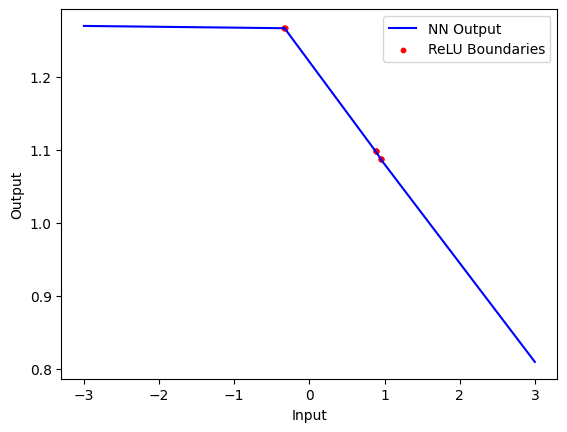

In [ ]:
simple_network = MLP_ReLU(1, [5, 5, 1])
visualize_1D_boundaries(simple_network)

<ipython-input-34-27662222eaae>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(torch.DoubleTensor(x).unsqueeze(1), dtype=torch.double)


1.4197532038906502e-12


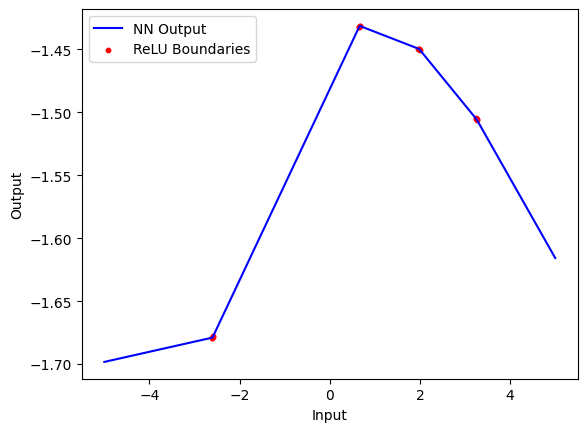

In [ ]:
visualize_1D_boundaries(simple_network)

<ipython-input-12-6c6f0eef5a90>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.init.xavier_normal_(torch.tensor(m.weight, dtype=torch.double))


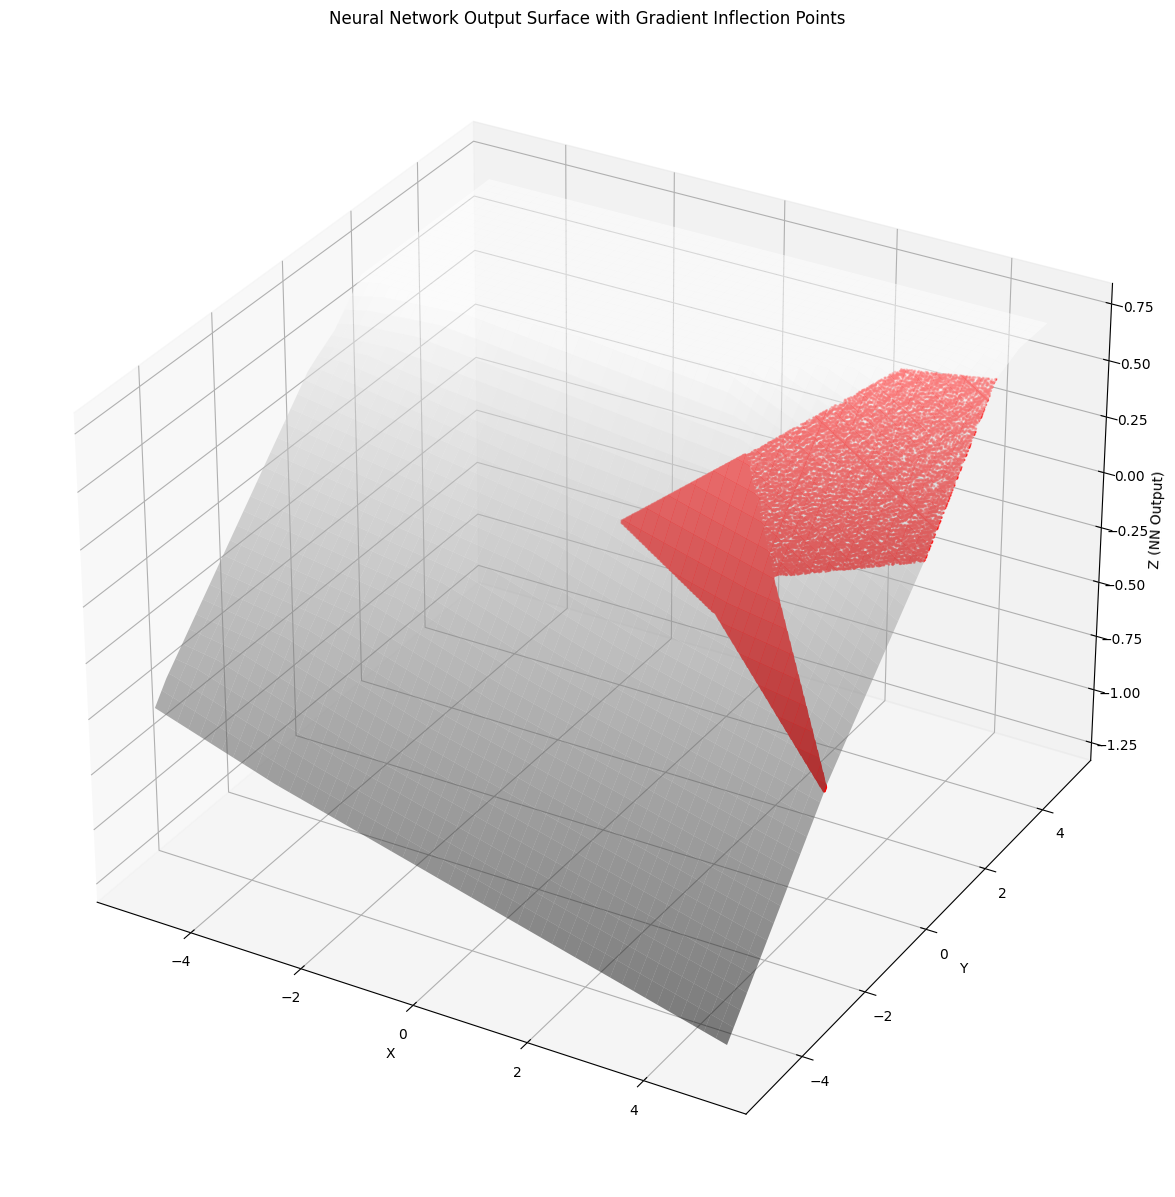

In [ ]:
def visualize_surface_2d(model, x_range=(-5, 5), y_range=(-5, 5), num_points=1000):
    x_min, x_max = x_range
    y_min, y_max = y_range

    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)

    X, Y = np.meshgrid(x, y)
    input_points = np.array([X.flatten(), Y.flatten()]).T
    input_points = input_points.astype(np.double)
    input_points_tensor = torch.tensor(input_points, dtype=torch.double).double()

    with torch.no_grad():
        Z = model(input_points_tensor).numpy()

    Z = Z.reshape(X.shape)

    # Compute the gradient magnitude of Z with respect to both X and Y
    dZ_dX, dZ_dY = np.gradient(Z, axis=(1, 0), edge_order=2)
    grad_magnitude = np.sqrt(dZ_dX**2 + dZ_dY**2)

    # Identify significant changes in gradient magnitude
    inflection_threshold = np.percentile(grad_magnitude, 95)  # e.g., 95th percentile
    inflection_points = (grad_magnitude > inflection_threshold)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='gray', alpha=0.5)

    # Overlay the inflection points (change points in gradient)
    ax.scatter(X[inflection_points], Y[inflection_points], Z[inflection_points], color='red', s=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (NN Output)')
    ax.set_title('Neural Network Output Surface with Gradient Inflection Points')
    plt.show()

# Create and visualize a sample model
model = MLP_ReLU(2, [5, 5, 1]).double()
visualize_surface_2d(model)


In [ ]:
def complex_step_gradient(model, input_point, epsilon=1e-20):
    """
    Estimate the gradient of a black-box PyTorch model using complex-step derivative approximation
    and vectorized batch computation with vmap.

    :param model: The black-box PyTorch model (a callable function).
    :param input_point: The input point (NumPy array) at which to compute the gradient.
    :param epsilon: The perturbation value for complex-step approximation.
    :return: The estimated gradient (NumPy array) at the input point.
    """

    # Convert the input_point to a complex NumPy array
    x = input_point.astype(np.complex128)

    # Create a perturbation matrix (each row is a perturbed input) using broadcasting
    perturbation_matrix = np.eye(len(x), dtype=np.complex128) * 1j * epsilon

    # Compute the perturbed inputs
    x_perturbed = x + perturbation_matrix

    # Convert the perturbed inputs to PyTorch tensors
    x_perturbed_torch = torch.tensor(x_perturbed, dtype=torch.cfloat)

    # Apply the model to each perturbed input using vmap
    f_x_perturbed = torch.imag(torch.vmap(model)(x_perturbed_torch)).double().numpy()

    # Compute the complex-step approximation for the gradient
    grad = f_x_perturbed / epsilon

    return grad

def compute_second_order_gradient(model, input_point, epsilon=1e-3):

    # Create a perturbation matrix (each row is a perturbed input)
    perturbation_matrix = np.eye(input_point.size) * epsilon
    x_perturbed_positive = input_point + perturbation_matrix
    x_perturbed_negative = input_point - perturbation_matrix

    # Compute the function values f(X_i) for all perturbed inputs
    # using vmap to batch the computation
    f_prime_x_perturbed_positive = compute_gradient_vmap(model, x_perturbed_positive, epsilon)
    f_prime_x_perturbed_negative = compute_gradient_vmap(model, x_perturbed_negative, epsilon)

    # Compute the central difference approximation for the gradient
    second_order_grad = (f_prime_x_perturbed_positive - f_prime_x_perturbed_negative) / (2 * epsilon)

    return second_order_grad

def compute_partial_derivative(model, input_point, direction, epsilon=1e-3):
    """
    Estimate the partial gradient of a black-box deep ReLU network with respect to a given direction
    """
    # Convert the input_point to a PyTorch tensor
    x_input = torch.from_numpy(input_point).double()
    x_perturb = torch.from_numpy(input_point + epsilon * direction).double()


    f_x = model(x_input).detach().clone()
    f_x_perturbed = model(x_perturb).detach().clone()

    partial_derivative = (f_x_perturbed - f_x) / epsilon

    return partial_derivative.numpy()

def compute_gradient_vmap(model, input_point, epsilon=1e-3):
    """
    Estimate the gradient of a black-box deep ReLU network using central differences and vmap.

    :param model: The black-box PyTorch model (a callable function).
    :param input_point: The input point (NumPy array) at which to compute the gradient.
    :param epsilon: The perturbation value for central differences.
    :return: The estimated gradient (NumPy array) at the input point.
    """

    # Create a perturbation matrix (each row is a perturbed input)
    perturbation_matrix = np.eye(input_point.size) * epsilon
    x_perturbed_positive = torch.from_numpy(input_point + perturbation_matrix).double()
    x_perturbed_negative = torch.from_numpy(input_point - perturbation_matrix).double()

    # Compute the function values f(X_i) for all perturbed inputs
    # using vmap to batch the computation
    f_x_perturbed_positive = torch.vmap(model)(x_perturbed_positive).detach().numpy(dtype=np.double)
    f_x_perturbed_negative = torch.vmap(model)(x_perturbed_negative).detach().numpy(dtype=np.double)

    # Compute the central difference approximation for the gradient
    grad = (f_x_perturbed_positive - f_x_perturbed_negative) / (2 * epsilon)

    return grad

